## Access Satellite GHRSST L3S 1Day Day and night time Single Sensor Southern Ocean data in Zarr
A jupyter notebook to show how to access and plot the AODN satellite_ghrsst_l3s_1day_daynighttime_single_sensor_southernocean dataset available as a [Zarr](https://zarr.dev/) dataset on S3.

More information about the dataset available at [here](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/165a23d7-5ef3-4cab-9e02-90c8adb941dd).

📌 The point of truth for this notebook is [on GitHub](https://github.com/aodn/aodn_cloud_optimised/tree/main/notebooks/satellite_ghrsst_l3s_1day_daynighttime_single_sensor_southernocean.ipynb).

In [1]:
dataset_name = "satellite_ghrsst_l3s_1day_daynighttime_single_sensor_southernocean"

## Install/Update packages and Load common functions

In [2]:
import os, requests, importlib.util

open('setup.py', 'w').write(requests.get('https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/setup.py').text)

spec = importlib.util.spec_from_file_location("setup", "setup.py")
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

setup.install_requirements()
setup.load_dataquery()

Using CPython 3.12.11 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python3
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Using Python 3.12.11 environment at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised
Resolved 241 packages in 1.19s
Audited 241 packages in 5ms
/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:3445: UserWarning: registration of accessor <class 'DataQuery.AODNAccessor'> under name 'aodn' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  @pd.api.extensions.register_dataframe_accessor("aodn")


✅ Local version 0.3.2 is up to date (remote: 0.3.2)


In [3]:
from DataQuery import GetAodn

/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:3445: UserWarning: registration of accessor <class 'DataQuery.AODNAccessor'> under name 'aodn' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  @pd.api.extensions.register_dataframe_accessor("aodn")


# Understanding the Dataset

In [4]:
# remote zarr dataset
aodn = GetAodn()
dname = f'{dataset_name}.zarr'
%time aodn_dataset = aodn.get_dataset(dname)

CPU times: user 631 ms, sys: 108 ms, total: 739 ms
Wall time: 1.89 s


## Plot time coverage

In [5]:
aodn_dataset.get_temporal_extent()

(Timestamp('1992-03-21 11:10:00'), Timestamp('2008-08-27 11:10:00'))

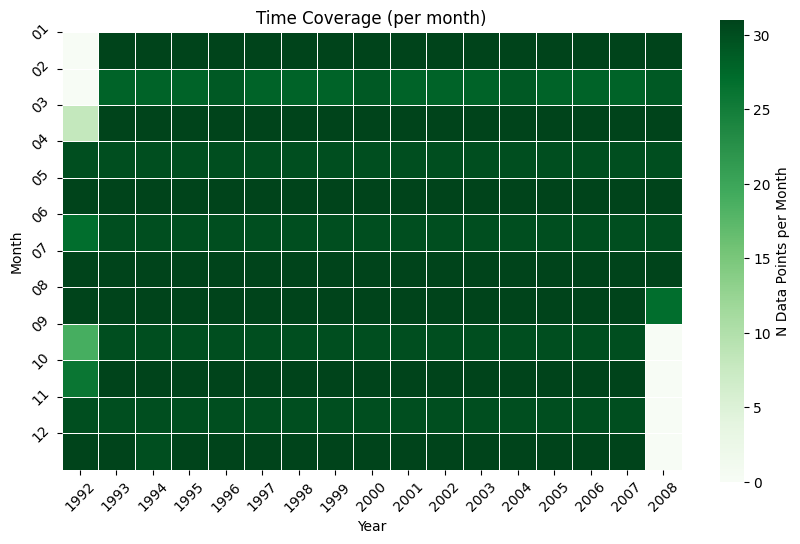

In [6]:
aodn_dataset.plot_time_coverage()

## Timeseries at a point

/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:1469: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled = df[self.var_name].resample(resample)


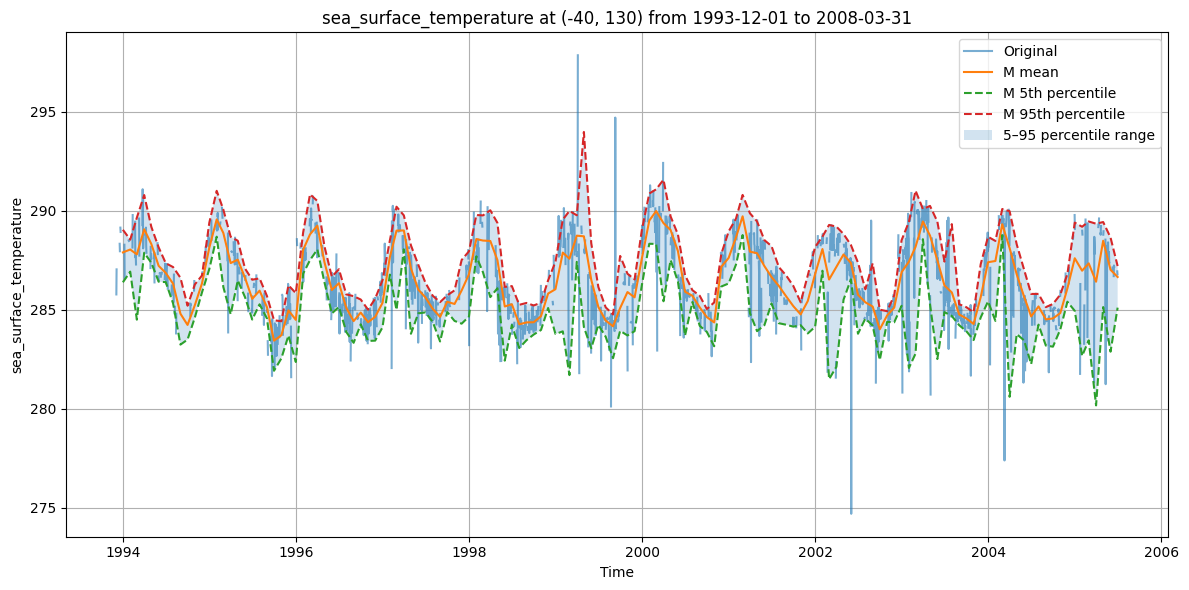

CPU times: user 8.16 s, sys: 1.89 s, total: 10 s
Wall time: 44.6 s
CPU times: user 8.16 s, sys: 1.89 s, total: 10.1 s
Wall time: 44.6 s


In [13]:
%%time
%%time
time_series_df = aodn_dataset.get_timeseries_data(var_name='sea_surface_temperature', 
                                                  lat=-40, 
                                                  lon=130, 
                                                  date_start='1993-12-01', 
                                                  date_end='2008-03-31', 
                                                  lon_name_override="lon", 
                                                  lat_name_override="lat").plot_timeseries()

## Plot a gridded variable

In [12]:
%%time
time_series_df = aodn_dataset.plot_gridded_variable(var_name='sea_surface_temperature', 
                                                    date_start='2006-02-26',                                                
                                                    lon_name_override="lon", 
                                                    lat_name_override="lat", 
                                                    lon_slice=(110, 140), 
                                                    lat_slice=(-50, -40), 
                                                    n_days=6, 
                                                    coastline_resolution="110m", 
                                                    log_scale=False)

2026-01-27 10:24:28,346 - aodn.GetAodn - INFO - Plotting 'sea surface foundation temperature' for 6 time steps.
2026-01-27 10:24:29,200 - aodn.GetAodn - WARNING - No valid data found across all selected dates and coordinates to determine color scale.


CPU times: user 234 ms, sys: 14.6 ms, total: 248 ms
Wall time: 870 ms


2026-01-27 10:22:42,173 - aodn.GetAodn - INFO - Plotting 'sea ice fraction' for 3 time steps.
/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:2869: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(


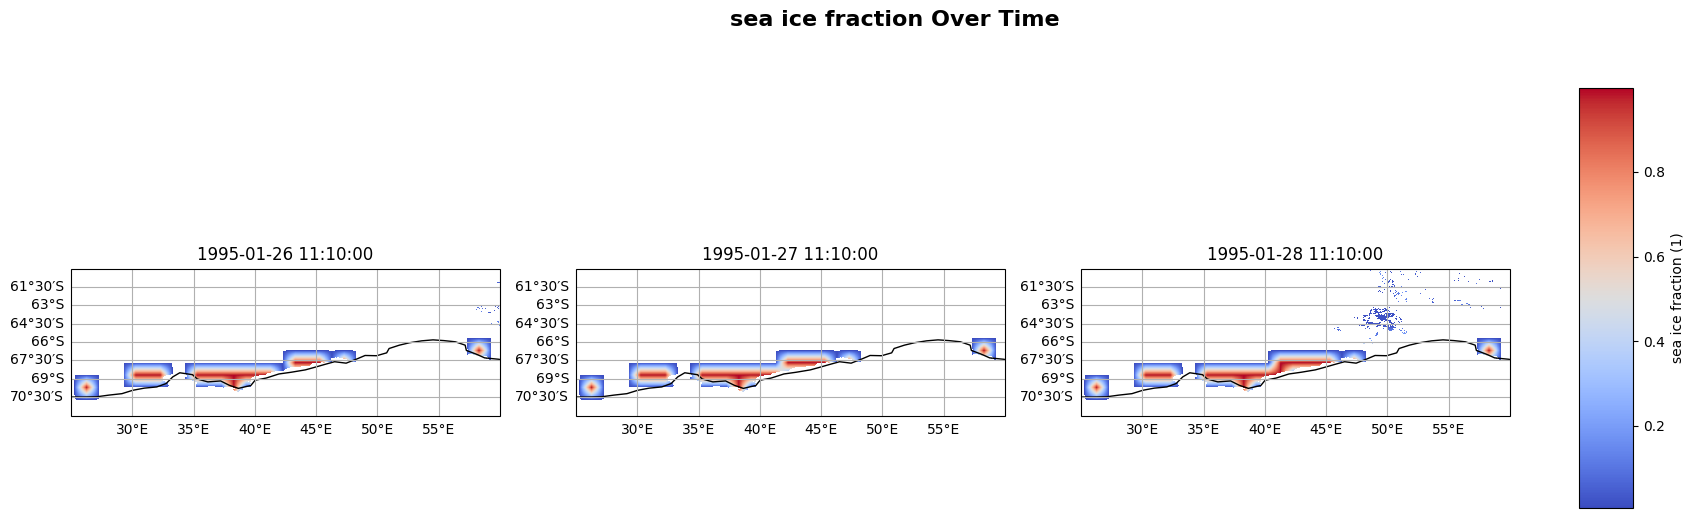

CPU times: user 2.42 s, sys: 1.84 s, total: 4.26 s
Wall time: 2.8 s


In [9]:
%%time
time_series_df = aodn_dataset.plot_gridded_variable(var_name='sea_ice_fraction', 
                                                    date_start='1995-01-26',                                                
                                                    lon_name_override="lon", 
                                                    lat_name_override="lat", 
                                                    lon_slice=(25, 60), 
                                                    lat_slice=(-72, -60), 
                                                    n_days=3, 
                                                    coastline_resolution="110m", 
                                                    log_scale=False)